In [1]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = LuxAI_S2() # create the environment object
obs, _ = env.reset(seed=41) # resets an environment with a seed

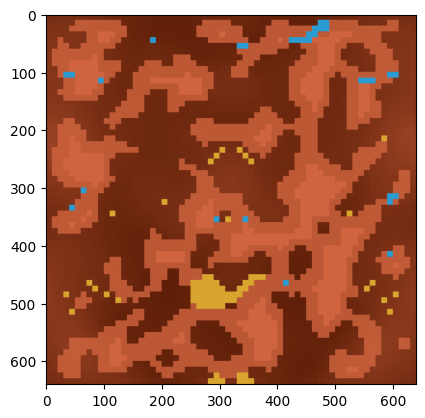

In [3]:
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [4]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
import torch
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg
        self.factory_score = None

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        # optionally convert observations to python objects with utility functions
        game_state = obs_to_game_state(step, self.env_cfg, obs) 
        return actions

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        return actions

In [5]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs, _ = env.reset()
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
#         print(termination)
        dones = {k: terminations[k] or truncations[k] for k in terminations}
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
        dones = {k: terminations[k] or truncations[k] for k in terminations}
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

In [6]:
# https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv2d(a, f, pad='zero', n=1):
    if pad == 'zero':
        pad = (f.shape[0] - 1) // 2

    strd = np.lib.stride_tricks.as_strided
    a = np.pad(a, pad)
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    for i in range(n):
        if i > 0:
            a = np.pad(a, pad)
        subM = strd(a, shape = s, strides = a.strides * 2)
        a = np.einsum('ij,ijkl->kl', f, subM)
    return a

In [7]:
def average_kernel(size):
    return np.ones((size, size)) / (size * size)

In [8]:
a = np.ones((5, 5))
k = average_kernel(3)
conv2d(a, k)

array([[0.44444444, 0.66666667, 0.66666667, 0.66666667, 0.44444444],
       [0.66666667, 1.        , 1.        , 1.        , 0.66666667],
       [0.66666667, 1.        , 1.        , 1.        , 0.66666667],
       [0.66666667, 1.        , 1.        , 1.        , 0.66666667],
       [0.44444444, 0.66666667, 0.66666667, 0.66666667, 0.44444444]])

In [26]:
def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
    if step == 0:
        # bid 0 to not waste resources bidding and declare as the default faction
        # you can bid -n to prefer going second or n to prefer going first in placement
        return dict(faction="AlphaStrike", bid=0)
    else:
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        # factory placement period
        if self.factory_score is None:
            map_size = self.env_cfg.map_size
            self.factory_score = np.zeros((map_size, map_size))
            self.factory_score += conv2d(game_state.board.rubble, average_kernel(5), n=3)
            ice_tile_locations = np.argwhere(game_state.board.ice == 1)
            all_locations = np.mgrid[:map_size, :map_size].swapaxes(0, 2).reshape(-1, 2)
            distances = np.linalg.norm(np.expand_dims(all_locations, 1) - np.expand_dims(ice_tile_locations, 0), ord=1, axis=-1)
            distances = np.min(distances, axis=-1)
            distances = distances.reshape(map_size, map_size)
            # distances[x][y] is the distance to the nearest ice tile 
            self.factory_score += distances
        
        # how much water and metal you have in your starting pool to give to new factories
        water_left = game_state.teams[self.player].water
        metal_left = game_state.teams[self.player].metal
        
        # how many factories you have left to place
        factories_to_place = game_state.teams[self.player].factories_to_place
        # whether it is your turn to place a factory
        my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
        if factories_to_place > 0 and my_turn_to_place:
            # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
            factory_score = self.factory_score + (obs["board"]["valid_spawns_mask"] == 0) * 1e9
            spawn_loc = np.argmin(factory_score)
            map_size = self.env_cfg.map_size
            spawn_loc = np.array([spawn_loc // map_size, spawn_loc % map_size])
            return dict(spawn=spawn_loc, metal=150, water=150)
        return dict()
Agent.early_setup = early_setup

In [28]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 15)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [35]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    for unit_id, unit in units.items():
        
        # track the closest factory
        closest_factory = None
        adjacent_to_factory = False
        if len(factory_tiles) > 0:
            factory_distances = np.linalg.norm(factory_tiles - unit.pos, ord=1, axis=1)
            closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
            closest_factory = factory_units[np.argmin(factory_distances)]
            adjacent_to_factory = np.linalg.norm(closest_factory_tile - unit.pos, ord=1) == 0

            ice_threshold = 40
            # previous ice mining code
            if adjacent_to_factory and unit.power < unit.unit_cfg.INIT_POWER:
                actions[unit_id] = [unit.pickup(4, unit.unit_cfg.BATTERY_CAPACITY, repeat=0, n=1)]
                # 4 means power
            elif unit.cargo.ice < ice_threshold:
                ice_tile_distances = np.linalg.norm(ice_tile_locations - unit.pos, ord=1, axis=1)
                closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                if np.all(closest_ice_tile == unit.pos):
                    if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.dig(repeat=0, n=1)]
                else:
                    direction = direction_to(unit.pos, closest_ice_tile)
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
            # else if we have enough ice, we go back to the factory and dump it.
            elif unit.cargo.ice >= ice_threshold:
                direction = direction_to(unit.pos, closest_factory_tile)
                if adjacent_to_factory:
                    if unit.power >= unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0, n=1)]
                    
                else:
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
    return actions
Agent.act = act

In [37]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 1000)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


## CLI Tool

To test your agent without using the python API you can also run

In [38]:
!rm *.webm *.mp4 
!rm -r __pycache__
!rm -r lux/__pycache__


In [ ]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

In [ ]:
import IPython # load the HTML replay
IPython.display.HTML(filename='replay.html')

which uses a seed of 101 and generates a replay.html file that you can click and watch. Optionally if you specify `-o replay.json` you can upload replay.json to http://s2vis.lux-ai.org/. We **highly recommend** watching on a separate window instead of watching here on a notebook as the notebook screen width is quite small.

The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/luxai_runner/README.md

In [39]:
!tar -cvzf * submission.tar.gz

agent.py
lux/
lux/__init__.py
lux/forward_sim.py
lux/config.py
lux/unit.py
lux/factory.py
lux/cargo.py
lux/team.py
lux/utils.py
lux/kit.py
main.py
replay.html
submission.tar.gz
tutorial.ipynb
submission.tar.gz
